# CNN interpretation with CAM

## CAM and hooks

In [2]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.181911,0.016683,0.006089,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.081984,0.015135,0.006089,00:19


In [3]:
img = PILImage.create('images/chapter1_cat_example.jpg')
x, = first(dls.test_dl([img]))

In [4]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [5]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [6]:
with torch.no_grad(): output = learn.model.eval()(x)

In [7]:
act = hook_output.stored[0]

In [8]:
x.shape

torch.Size([1, 3, 224, 224])

In [9]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

In [12]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])

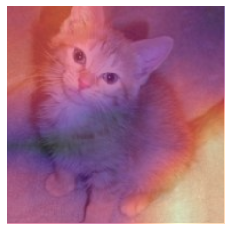

In [15]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[0].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [19]:
dls.vocab

(#2) [False,True]

In [23]:
F.softmax(output, dim=-1)

tensor([[9.9964e-01, 3.5779e-04]], device='cuda:0')

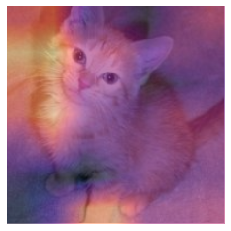

In [22]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [24]:
hook.remove()

In [25]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [27]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored

## Gradient CAM

In [28]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [40]:
cls = 0
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [41]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

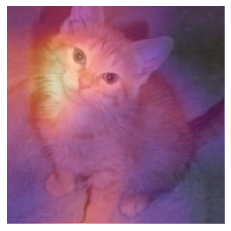

In [42]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [45]:
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

In [46]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

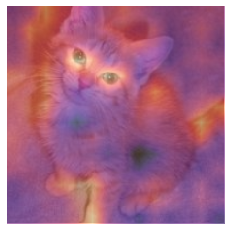

In [47]:
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');